# Figure S1: AABW thickness

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import cftime
import sys
sys.path.append(
    "/g/data/e14/cs6673/Ross_salinity/Python_scripts_published/") 
from Info_definitions import (
    path_database, path_plots, exptdict, yearly_mean,
    shelf_mask_isobath, select_bottom_values)

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
import string

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38037/status,
Dashboard: /proxy/38037/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40157,Workers: 7
Dashboard: /proxy/38037/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:44845,Total threads: 4
Dashboard: /proxy/43611/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:40459,


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/protocol/pickle.py", line 63, in dumps
    result = pickle.dumps(x, **dump_kwargs)
AttributeError: Can't pickle local object 'getvar.<locals>._preprocess'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/protocol/pickle.py", line 68, in dumps
    pickler.dump(x)
AttributeError: Can't pickle local object 'getvar.<locals>._preprocess'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps

## Load data

In [4]:
%%time
ekeys = ['ctrl', 'wind_50_down_zonal', 'mw_50_down']
start_time = '2150-01-01'
end_time = '2159-12-31'

ht = cc.querying.getvar(
    exptdict['ctrl']['expt'], 'ht',
    session=cc.database.create_session(), n=1).sel(
    yt_ocean=slice(-90, -60))
ht_shelf, shelf_mask = shelf_mask_isobath(ht, output_mask=True)
land_mask = (ht*0).fillna(1)

for ekey in ekeys:
    print(ekey)
    e = exptdict[ekey]
    if ekey == 'ctrl':
        session = cc.database.create_session()
    else:
        db = (path_database + e['expt'] + '.db')
        session = cc.database.create_session(db)

    e['dzt'] = cc.querying.getvar(
        e['expt'], 'dzt', session, frequency='1 monthly',
        chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'}).sel(
        yt_ocean=slice(None, -60), xt_ocean=slice(-240, -60))
    dzt_total = e['dzt'].sum('st_ocean')
    e['dzt_total'] = dzt_total.where(dzt_total != 0)

    e['rho0'] = cc.querying.getvar(
        e['expt'], 'pot_rho_0', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
            yt_ocean=slice(None, -60), xt_ocean=slice(-240, -60)) - 1000

ctrl
wind_50_down_zonal
mw_50_down
CPU times: user 5.25 s, sys: 760 ms, total: 6.01 s
Wall time: 29.5 s


In [5]:
def Fig_S1(ekeys, rho_min, v_max=500, v_max_diff=50, time=None):
    
    fig, ax = plt.subplots(
            3, 1, figsize=(8, 12), subplot_kw={
                'projection': ccrs.PlateCarree(central_longitude=185)})
    plt.subplots_adjust(hspace=.14)
    proj = ccrs.PlateCarree()

    for p, ekey in enumerate(ekeys):
    
        ax[p].contourf(land_mask.xt_ocean, land_mask.yt_ocean,
                    land_mask, colors='silver', levels=[0.5, 2],
                    zorder=2, transform=proj)
    
        ax[p].set_extent([120, 210, -79, -61])
        gl = ax[p].gridlines(draw_labels=False)
        gl.xlocator = mticker.FixedLocator(
            [140, 160, 180, -160])
        if p == len(ekeys)-1:
            ax[p].set_xticks([140, 180], crs=proj)
        ax[p].xaxis.set_major_formatter(LongitudeFormatter(
            dateline_direction_label=True))
        gl.ylocator = mticker.FixedLocator(
            np.arange(-80, -60, 5))
        ax[p].set_yticks(np.arange(-80, -60, 5), crs=proj)
        ax[p].yaxis.set_major_formatter(LatitudeFormatter())
        ax[p].set_ylim(-79, None)
        ax[p].set_aspect('auto')
    
        ax[p].contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask,
                    levels=[0, 1], colors = 'k',  transform=proj)
        ax[p].contour(ht.xt_ocean, ht.yt_ocean, ht,
                    levels=[3000], colors = 'grey',  transform=proj)

        e =  exptdict[ekey]
        var = e['dzt'].where(e['rho0'] >= rho_min).sum('st_ocean').sel(
            time=time)
        if ekey == 'ctrl':
            var_ctrl = var.copy()
            var = yearly_mean(var).mean('time')
            var = var.where(var != 0)

            pc = ax[p].pcolormesh(
                var.xt_ocean, var.yt_ocean, var, cmap=cmo.deep,
                vmin=0, vmax=v_max, transform=proj)
            cb_ext = 'max'

            ax[p].set_title(
                string.ascii_lowercase[p] + ') ' + e['expt_str'],
                fontweight='bold', loc='left')
            ax[p].text(-189.5, -69.9, 'Cape Adare', color='k',
                       fontsize=11, transform=proj)
            ax[p].text(-168, -71, 'Amundsen-\nBellingshausen\nBasin',
                       color='k', va='top',
                       fontsize=11, transform=proj)
            ax[p].text(-194, -76, 'Drygalski\nTrough', color='k',
                       rotation=55, fontsize=11, transform=proj)
            ax[p].text(-184, -78.5, 'Glomar Chal-\nlenger Trough', color='k',
                       rotation=45, fontsize=11, transform=proj)
        else:
            var = var - var_ctrl
            var = yearly_mean(var).mean('time')

            pc = ax[p].pcolormesh(
                var.xt_ocean, var.yt_ocean, var, cmap=cmo.balance,
                vmin=-v_max_diff, vmax=v_max_diff, transform=proj)
            cb_ext = 'both'

            ax[p].set_title(
                string.ascii_lowercase[p] + ') ' + e['expt_str'] + '  -  ' +
                exptdict['ctrl']['expt_str'], fontweight='bold', loc='left')
        ax[p].plot([-191.5, -189.5, -189.5, -191.5, -191.5],
                   [-70.3, -70.3, -69, -69, -70.3],
                   color='magenta', transform=proj)

        pos = ax[p].get_position()
        cax = plt.axes([pos.xmax+.015, pos.ymin,
                        0.025, pos.ymax-pos.ymin])
        cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend=cb_ext)
        cb.ax.set_title('m')
    
    # plt.savefig(path_plots + 'FigS1.png', dpi=300, bbox_inches="tight")
    plt.show()

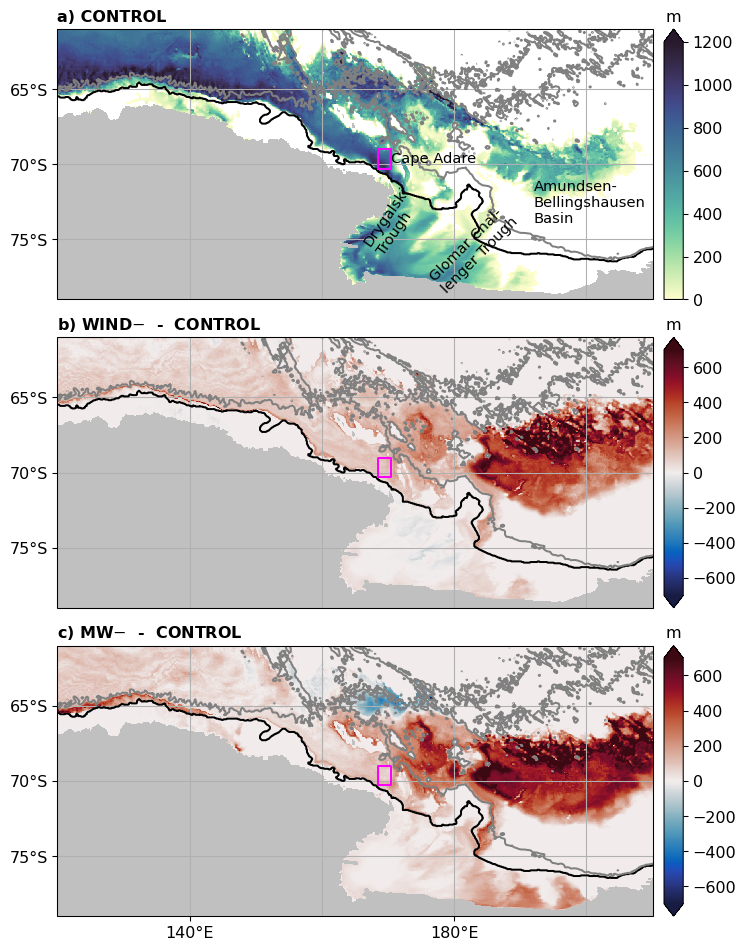

In [6]:
time = slice('2155-01', '2159-12')
rho_min = 27.86
v_max = 1200
v_max_diff = 700

Fig_S1(ekeys, rho_min, v_max, v_max_diff, time)